In [24]:
import pandas as pd
import numpy as np
from datetime import datetime

# Funções da Pipeline
def load_data(file_path):
    """Carrega o dataset a partir de um arquivo CSV."""
    return pd.read_csv(file_path)

def clean_dates(df, column="Data_Pedido"):
    """Padroniza as datas para o formato YYYY-MM-DD."""
    def parse_date(date_str):
        if pd.isna(date_str):
            return np.nan
        for fmt in ("%Y-%m-%d", "%d/%m/%Y", "%d-%m-%y", "%d/%m/%y"):
            try:
                return pd.to_datetime(date_str, format=fmt)
            except ValueError:
                continue
        return np.nan
    
    df[column] = df[column].apply(parse_date)
    return df

def clean_values(df, column="Valor_Compra"):
    """Converte valores monetários para float, removendo 'R$'."""
    def clean_valor(valor):
        if pd.isna(valor):
            return np.nan
        if isinstance(valor, str):
            return float(valor.replace("R$ ", "").replace(",", "."))
        return float(valor)
    
    df[column] = df[column].apply(clean_valor)
    return df

def handle_missing(df):
    """Trata valores ausentes em Nome_Cliente e Valor_Compra."""
    df["Nome_Cliente"] = df["Nome_Cliente"].fillna("Desconhecido")
    medianas = df.groupby("Categoria_Produto")[ "Valor_Compra"].median()
    df["Valor_Compra"] = df.apply(
        lambda row: medianas[row["Categoria_Produto"]] if pd.isna(row["Valor_Compra"]) else row["Valor_Compra"],
        axis=1
    )
    return df

def normalize_names(df, column="Nome_Cliente"):
    """Normaliza nomes de clientes (ex.: 'João Silva' e 'Joao Silva')."""
    def normalize_name(nome):
        if "Desconhecido" in nome:
            return "Desconhecido"
        nome = nome.lower().replace("123", "").strip()
        return "João Silva" if "joao" in nome or "joão" in nome else nome.capitalize()
    
    df[column] = df[column].apply(normalize_name)
    return df

def standardize_categories(df, column="Categoria_Produto"):
    """Padroniza categorias de produtos."""
    categoria_map = {
        "smartphone": "Smartphone", "celular": "Smartphone",
        "laptop": "Notebook", "notebook": "Notebook",
        "televisão": "TV", "tv": "TV",
        "fone de ouvido": "Fone de Ouvido",
        "acessórios": "Acessórios"
    }
    df[column] = df[column].str.lower().map(categoria_map).fillna(df[column].str.capitalize())
    return df

def remove_duplicates(df, column="ID_Pedido"):
    """Remove duplicatas com base em uma coluna única."""
    return df.drop_duplicates(subset=column, keep="first")

def remove_outliers(df, column="Valor_Compra", threshold=3):
    """Remove outliers com base em z-score."""
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
    return df[z_scores < threshold]

# Função principal da Pipeline
def data_pipeline(file_path):
    """Executa a pipeline completa de tratamento de dados."""
    df = load_data(file_path)
    df = clean_dates(df)
    df = clean_values(df)
    df = handle_missing(df)
    df = normalize_names(df)
    df = standardize_categories(df)
    df = remove_duplicates(df)
    df = remove_outliers(df)
    return df

# Executar a Pipeline
file_path = "vendas_online_sujas.csv"  # Ajuste o caminho conforme necessário
df_clean = data_pipeline(file_path)

# Verificar o resultado
print("Dataset após a pipeline:")
display(df_clean.head())
print("\nInformações:")
print(df_clean.info())
print("\nValores ausentes:")
print(df_clean.isnull().sum())

# Salvar o dataset limpo (opcional)
df_clean.to_csv("vendas_online_limpo.csv", index=False)
print("Dataset limpo salvo como 'vendas_online_limpo.csv'.")

Dataset após a pipeline:


,ID_Pedido,Nome_Cliente,Valor_Compra,Data_Pedido,Categoria_Produto
0,P0001,Ana costa,3974.76,2022-06-28,Notebook
1,P0002,João Silva,4385.25,2023-11-23,Smartphone
2,P0003,Pedro santos,1103.51,2022-02-14,Smartphone
3,P0004,Maria oliveira,3849.32,2024-02-06,Acessórios
4,P0005,João Silva,4879.59,2022-09-30,Fone de Ouvido



Informações:
<class 'pandas.core.frame.DataFrame'>
Index: 995 entries, 0 to 999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID_Pedido          995 non-null    object        
 1   Nome_Cliente       995 non-null    object        
 2   Valor_Compra       995 non-null    float64       
 3   Data_Pedido        995 non-null    datetime64[ns]
 4   Categoria_Produto  995 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 46.6+ KB
None

Valores ausentes:
ID_Pedido            0
Nome_Cliente         0
Valor_Compra         0
Data_Pedido          0
Categoria_Produto    0
dtype: int64
Dataset limpo salvo como 'vendas_online_limpo.csv'.


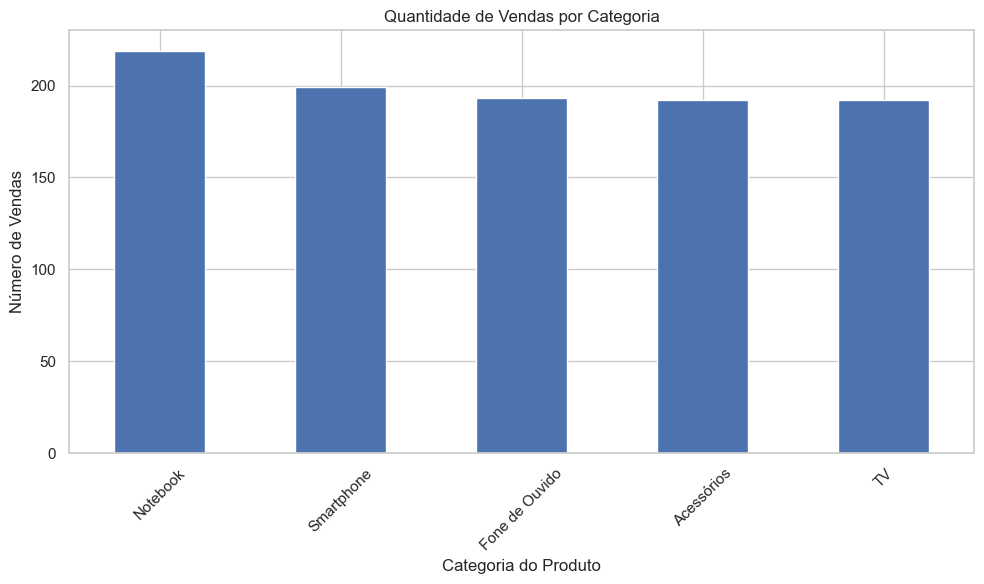

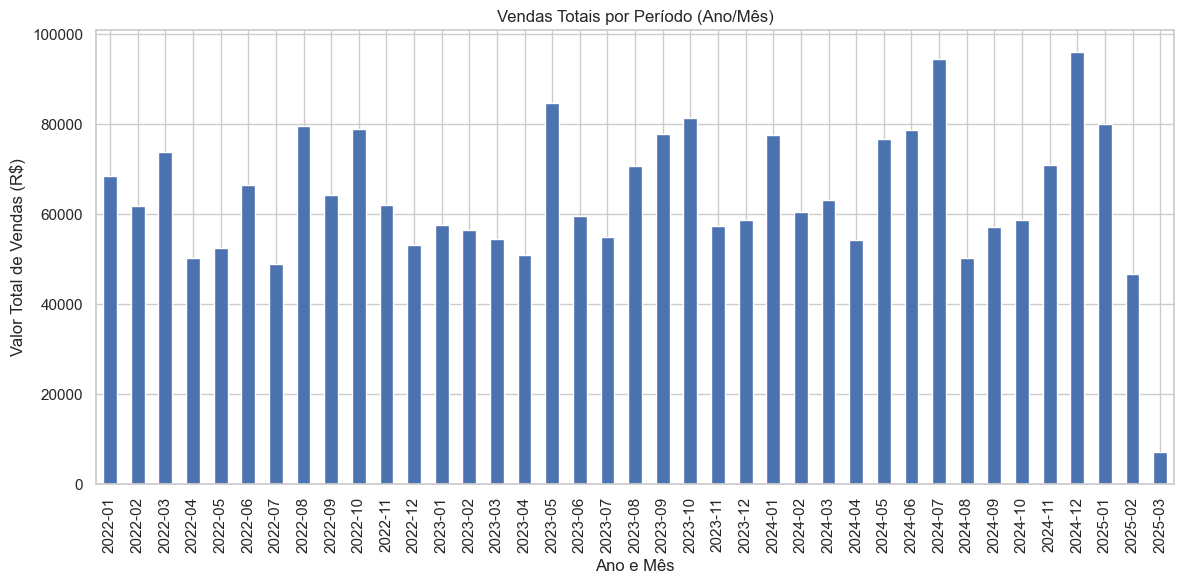

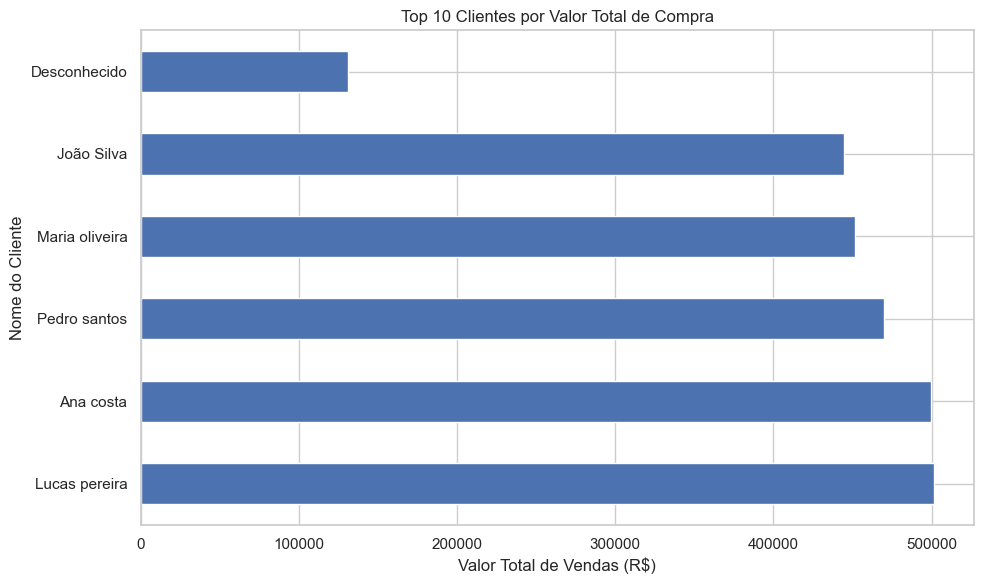

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração de estilo com Seaborn
sns.set(style="whitegrid")
sns.set_palette("deep")

# Adicionar coluna Ano_Mes para análises temporais
df_clean["Ano_Mes"] = df_clean["Data_Pedido"].dt.to_period("M")

# 1. Quantidade de Vendas por Categoria
vendas_por_categoria = df_clean["Categoria_Produto"].value_counts()
plt.figure(figsize=(10, 6))
vendas_por_categoria.plot(kind="bar", title="Quantidade de Vendas por Categoria")
plt.xlabel("Categoria do Produto")
plt.ylabel("Número de Vendas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Período de Maior Venda (Ano/Mês)
vendas_por_periodo = df_clean.groupby("Ano_Mes")["Valor_Compra"].sum()
plt.figure(figsize=(12, 6))
vendas_por_periodo.plot(kind="bar", title="Vendas Totais por Período (Ano/Mês)")
plt.xlabel("Ano e Mês")
plt.ylabel("Valor Total de Vendas (R$)")
plt.xticks(rotation=90)
plt.tight_layout()


# 5. Top Clientes por Valor de Compra
top_clientes = df_clean.groupby("Nome_Cliente")["Valor_Compra"].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
top_clientes.plot(kind="barh", title="Top 10 Clientes por Valor Total de Compra")
plt.xlabel("Valor Total de Vendas (R$)")
plt.ylabel("Nome do Cliente")
plt.tight_layout()
plt.show()